# Continuous Control — DDPG with 20 Parallel Agents

Train a double-jointed arm to track moving target locations using **Deep Deterministic Policy Gradients (DDPG)**. The 20-agent version shares a single replay buffer and network to accelerate learning.

**Solve condition**: Average score ≥ 30 over 100 consecutive episodes.

### 1. Import Packages and Start the Environment

In [1]:
from unityagents import UnityEnvironment
import numpy as np
import torch
import matplotlib.pyplot as plt
from collections import deque

%matplotlib inline

In [2]:
env = UnityEnvironment(file_name='Reacher.app')

# Get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

INFO:unityagents:
'Academy' started successfully!


Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


### 2. Examine the State and Action Spaces

In [3]:
# Reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# Number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# Size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# Examine the state space
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 20
Size of each action: 4
There are 20 agents. Each observes a state with length: 33
The state for the first agent looks like: [ 0.00000000e+00 -4.00000000e+00  0.00000000e+00  1.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.00000000e+01  0.00000000e+00
  1.00000000e+00 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  5.75471878e+00 -1.00000000e+00
  5.55726624e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
 -1.68164849e-01]


### 3. Take Random Actions in the Environment

In [4]:
env_info = env.reset(train_mode=True)[brain_name]
states = env_info.vector_observations
scores = np.zeros(num_agents)
while True:
    actions = np.random.randn(num_agents, action_size)
    actions = np.clip(actions, -1, 1)
    env_info = env.step(actions)[brain_name]
    next_states = env_info.vector_observations
    rewards = env_info.rewards
    dones = env_info.local_done
    scores += env_info.rewards
    states = next_states
    if np.any(dones):
        break
print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

Total score (averaged over agents) this episode: 0.12


### 4. Train the Agent with DDPG

In [5]:
from ddpg_agent import Agent

agent = Agent(state_size=state_size, action_size=action_size,
              num_agents=num_agents, random_seed=42)

In [6]:
def ddpg_train(n_episodes=300, max_t=1000, print_every=10):
    """Train DDPG agent in the 20-agent Reacher environment.
    
    Returns:
        all_scores: list of average scores (across 20 agents) per episode
    """
    all_scores = []
    scores_window = deque(maxlen=100)
    solved = False
    
    for i_episode in range(1, n_episodes + 1):
        env_info = env.reset(train_mode=True)[brain_name]
        states = env_info.vector_observations
        agent.reset()
        scores = np.zeros(num_agents)
        
        for t in range(max_t):
            actions = agent.act(states)
            env_info = env.step(actions)[brain_name]
            next_states = env_info.vector_observations
            rewards = env_info.rewards
            dones = env_info.local_done
            agent.step(states, actions, rewards, next_states, dones, t)
            states = next_states
            scores += rewards
            if np.any(dones):
                break
        
        avg_score = np.mean(scores)
        all_scores.append(avg_score)
        scores_window.append(avg_score)
        rolling_avg = np.mean(scores_window)
        
        if i_episode % print_every == 0:
            print('Episode {}\tAverage: {:.2f}'.format(
                i_episode, rolling_avg))
        
        if rolling_avg >= 30.0 and not solved:
            print('\nEnvironment solved at episode {:d}!\t100-Episode Average: {:.2f}'.format(
                i_episode, rolling_avg))
            torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
            torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
            solved = True
    
    # Save final weights if we haven't solved yet (or for the final state)
    if not solved:
        torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
        torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
    
    return all_scores

scores = ddpg_train()

Episode 10	Average: 0.15
Episode 20	Average: 0.26
Episode 30	Average: 0.42
Episode 40	Average: 1.02
Episode 50	Average: 1.99
Episode 60	Average: 3.40
Episode 70	Average: 5.14
Episode 80	Average: 7.00
Episode 90	Average: 9.37
Episode 100	Average: 11.83
Episode 110	Average: 15.40
Episode 120	Average: 19.04
Episode 130	Average: 22.66
Episode 140	Average: 26.11
Episode 150	Average: 29.23

Environment solved at episode 153!	100-Episode Average: 30.09
Episode 160	Average: 31.90
Episode 170	Average: 34.06
Episode 180	Average: 35.82
Episode 190	Average: 36.79
Episode 200	Average: 37.19
Episode 210	Average: 37.31
Episode 220	Average: 37.36
Episode 230	Average: 37.39
Episode 240	Average: 37.39
Episode 250	Average: 37.38
Episode 260	Average: 37.35
Episode 270	Average: 37.37
Episode 280	Average: 37.34
Episode 290	Average: 37.32
Episode 300	Average: 37.30


### 5. Plot Results

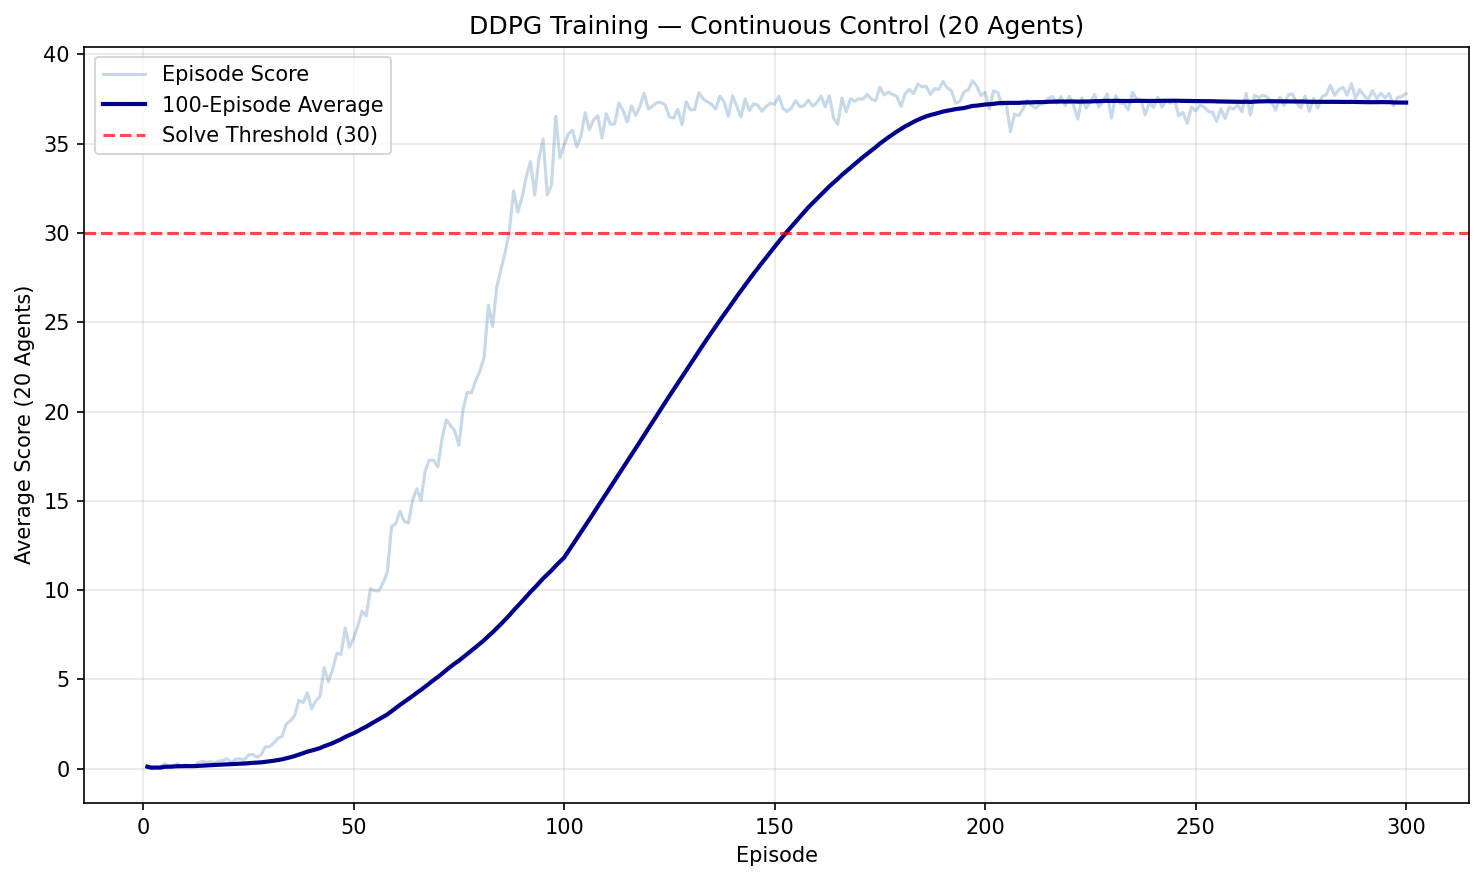

In [7]:
fig, ax = plt.subplots(figsize=(10, 6))

# Episode scores
ax.plot(np.arange(1, len(scores) + 1), scores, alpha=0.3, color='steelblue', label='Episode Score')

# 100-episode rolling average
if len(scores) >= 100:
    rolling = [np.mean(scores[max(0, i-100):i]) for i in range(1, len(scores) + 1)]
    ax.plot(np.arange(1, len(scores) + 1), rolling, color='darkblue', linewidth=2, label='100-Episode Average')

# Solve threshold
ax.axhline(y=30, color='red', linestyle='--', alpha=0.7, label='Solve Threshold (30)')

ax.set_xlabel('Episode')
ax.set_ylabel('Average Score (20 Agents)')
ax.set_title('DDPG Training — Continuous Control (20 Agents)')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('scores_plot.png', dpi=150, bbox_inches='tight')
plt.show()

### 6. Test the Trained Agent

Load saved weights and run 100 greedy episodes (no exploration noise) to verify performance.

In [8]:
# Load trained weights
from ddpg_agent import Agent as TestAgent

test_agent = TestAgent(state_size=state_size, action_size=action_size,
                       num_agents=num_agents, random_seed=42)
test_agent.actor_local.load_state_dict(torch.load('checkpoint_actor.pth', weights_only=True))

# Run 100 greedy test episodes
n_test = 100
test_scores = []

for i in range(1, n_test + 1):
    env_info = env.reset(train_mode=True)[brain_name]
    states = env_info.vector_observations
    episode_scores = np.zeros(num_agents)
    
    while True:
        actions = test_agent.act(states, add_noise=False)  # no exploration noise
        env_info = env.step(actions)[brain_name]
        states = env_info.vector_observations
        episode_scores += env_info.rewards
        if np.any(env_info.local_done):
            break
    
    avg = np.mean(episode_scores)
    test_scores.append(avg)
    print('\rTest Episode {}/{}\tScore: {:.2f}'.format(i, n_test, avg), end='')

print('\n\nGreedy Test Results ({} episodes):'.format(n_test))
print('  Average: {:.2f}'.format(np.mean(test_scores)))
print('  Std Dev: {:.2f}'.format(np.std(test_scores)))
print('  Min:     {:.2f}'.format(np.min(test_scores)))
print('  Max:     {:.2f}'.format(np.max(test_scores)))

Test Episode 100/100	Score: 39.16

Greedy Test Results (100 episodes):
  Average: 39.12
  Std Dev: 0.16
  Min:     38.71
  Max:     39.42


In [9]:
env.close()

### 7. Experimental Comparison — BatchNorm Ablation

To evaluate the impact of batch normalization, we compare the baseline DDPG agent (with BatchNorm) against an identical agent trained without BatchNorm. Both use the same hyperparameters, random seed, and architecture — only BatchNorm is toggled.

Both experiments were run via `train_experiment.py` and the results are loaded from the saved `.npy` files.

In [10]:
# Load results from both experiments
bn_scores = np.load('bn_scores.npy')
no_bn_scores = np.load('no_bn_scores.npy')
bn_losses = np.load('bn_losses.npz')
no_bn_losses = np.load('no_bn_losses.npz')
bn_test = np.load('bn_test_scores.npy')
no_bn_test = np.load('no_bn_test_scores.npy')

# Compute rolling averages
def rolling_avg(scores, window=100):
    return [np.mean(scores[max(0, i-window):i]) for i in range(1, len(scores) + 1)]

bn_rolling = rolling_avg(bn_scores)
no_bn_rolling = rolling_avg(no_bn_scores)

# Find solve episodes
bn_solve = next((i+1 for i, r in enumerate(bn_rolling) if r >= 30.0), None)
no_bn_solve = next((i+1 for i, r in enumerate(no_bn_rolling) if r >= 30.0), None)

print('=== Experimental Comparison: BatchNorm vs No BatchNorm ===')
print(f'\nWith BatchNorm:')
print(f'  Solved at episode:       {bn_solve}')
print(f'  Final 100-ep avg:        {bn_rolling[-1]:.2f}')
print(f'  Greedy test avg (100ep): {np.mean(bn_test):.2f} (σ={np.std(bn_test):.2f})')
print(f'\nWithout BatchNorm:')
print(f'  Solved at episode:       {no_bn_solve}')
print(f'  Final 100-ep avg:        {no_bn_rolling[-1]:.2f}')
print(f'  Greedy test avg (100ep): {np.mean(no_bn_test):.2f} (σ={np.std(no_bn_test):.2f})')

=== Experimental Comparison: BatchNorm vs No BatchNorm ===

With BatchNorm:
  Solved at episode:       153
  Final 100-ep avg:        37.30
  Greedy test avg (100ep): 39.12 (σ=0.16)

Without BatchNorm:
  Solved at episode:       164
  Final 100-ep avg:        37.50
  Greedy test avg (100ep): 39.44 (σ=0.08)


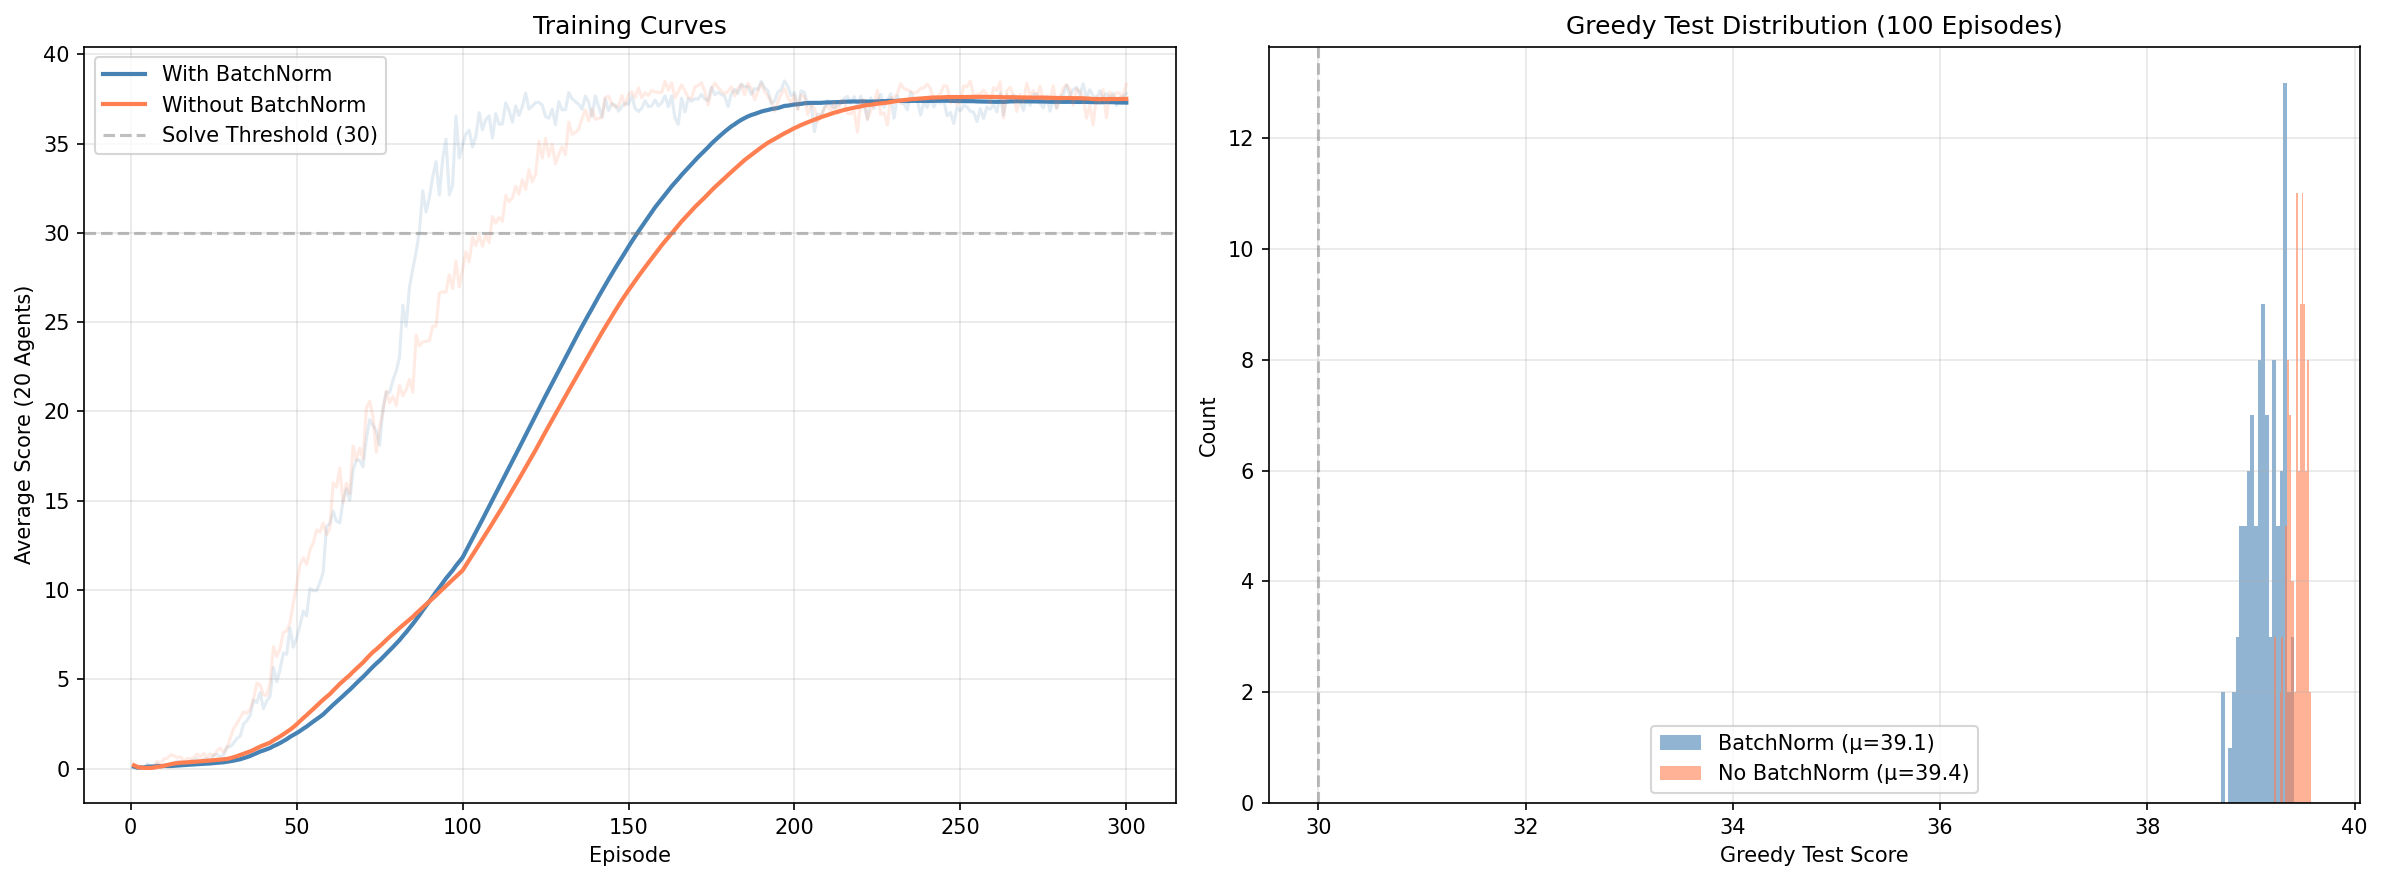

In [11]:
# --- Comparison Plot: Training Scores ---
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Left: Training curves
ax = axes[0]
episodes = np.arange(1, 301)
ax.plot(episodes, bn_scores, alpha=0.15, color='steelblue')
ax.plot(episodes, bn_rolling, color='steelblue', linewidth=2, label='With BatchNorm')
ax.plot(episodes, no_bn_scores, alpha=0.15, color='coral')
ax.plot(episodes, no_bn_rolling, color='coral', linewidth=2, label='Without BatchNorm')
ax.axhline(y=30, color='gray', linestyle='--', alpha=0.5, label='Solve Threshold (30)')
ax.set_xlabel('Episode')
ax.set_ylabel('Average Score (20 Agents)')
ax.set_title('Training Curves')
ax.legend()
ax.grid(True, alpha=0.3)

# Right: Greedy test distribution
ax = axes[1]
ax.hist(bn_test, bins=20, alpha=0.6, color='steelblue', label=f'BatchNorm (μ={np.mean(bn_test):.1f})')
ax.hist(no_bn_test, bins=20, alpha=0.6, color='coral', label=f'No BatchNorm (μ={np.mean(no_bn_test):.1f})')
ax.axvline(x=30, color='gray', linestyle='--', alpha=0.5)
ax.set_xlabel('Greedy Test Score')
ax.set_ylabel('Count')
ax.set_title('Greedy Test Distribution (100 Episodes)')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('experiment_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

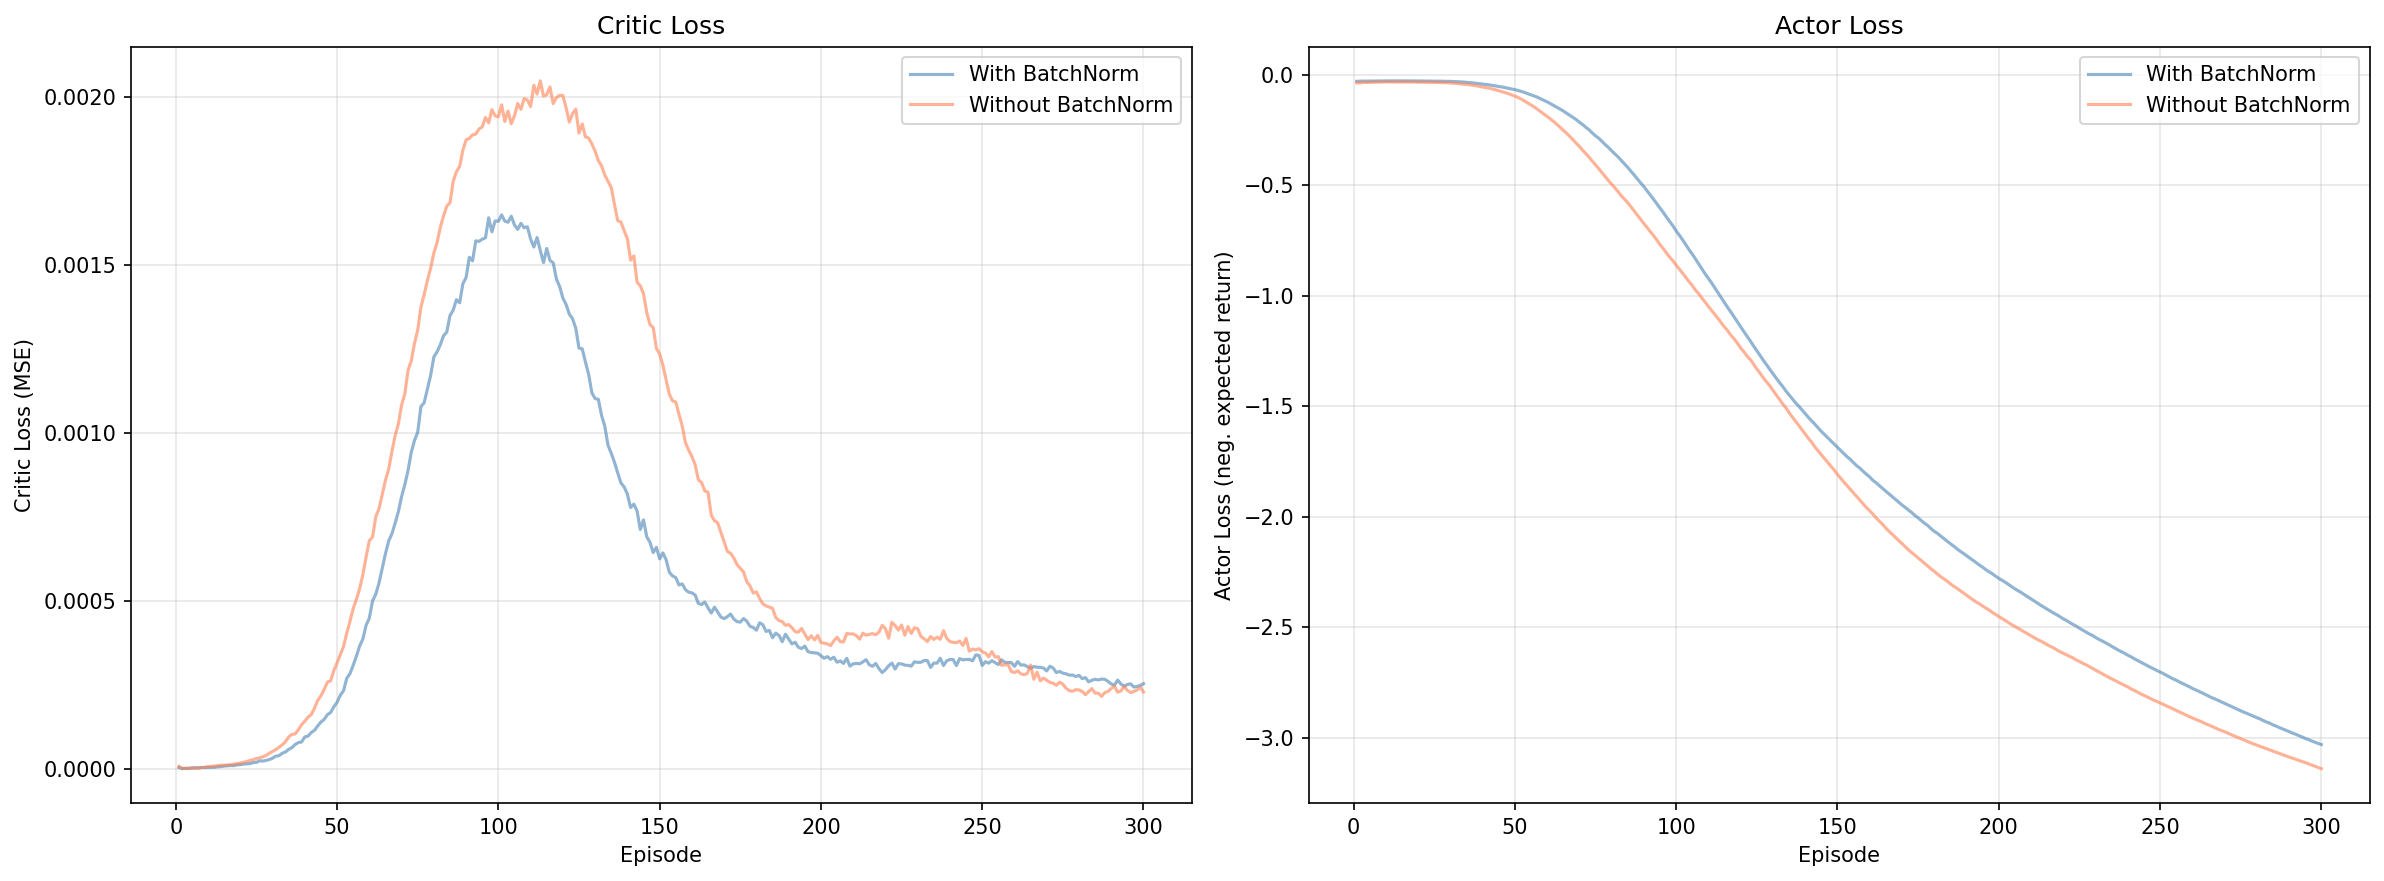

In [12]:
# --- Loss Curves ---
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

episodes = np.arange(1, 301)

# Critic loss
ax = axes[0]
ax.plot(episodes, bn_losses['critic_losses'], alpha=0.6, color='steelblue', label='With BatchNorm')
ax.plot(episodes, no_bn_losses['critic_losses'], alpha=0.6, color='coral', label='Without BatchNorm')
ax.set_xlabel('Episode')
ax.set_ylabel('Critic Loss (MSE)')
ax.set_title('Critic Loss')
ax.legend()
ax.grid(True, alpha=0.3)

# Actor loss
ax = axes[1]
ax.plot(episodes, bn_losses['actor_losses'], alpha=0.6, color='steelblue', label='With BatchNorm')
ax.plot(episodes, no_bn_losses['actor_losses'], alpha=0.6, color='coral', label='Without BatchNorm')
ax.set_xlabel('Episode')
ax.set_ylabel('Actor Loss (neg. expected return)')
ax.set_title('Actor Loss')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('loss_curves.png', dpi=150, bbox_inches='tight')
plt.show()